# Gill's model results: 

Plot Q1 in terms of w and h (tranangular and parobola)

In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as sio


In [2]:
# Compute scales for nondimensional variables
r = 6.371e+6
unit = 2*np.pi*r/360
Omega = 7.292e-5
g = 4e-4
Di = 1000
lat = -8
q = -1
f0 = abs(2*Omega*np.sin(lat/180*np.pi))
beta = 2*Omega*np.cos(lat/180*np.pi)/r
Ld = np.sqrt(g*Di)/f0
D = -q*Di
dn = 0.5

# Best guesses of Samoan Passage
wsn = np.array([1.6, .6])
hsn = np.array([.6, .4])
rsn = (np.power((np.array(wsn)/2.0), 2)/dn).tolist()

# other examples
wn = [0.6, 1.6, 2.8, 4.0]
hn = [0.2, 0.6, 0.8, 1.0, 1.4]
rn = (np.power((np.array(wn)/2.0), 2)/dn).tolist()

Q = 0.5
dQ = np.arange(0, Q - 1e-6, Q/5)

# coef for the model sqrt(|q|^(-1)+2Q)-|q|^(-1)
coef = np.sqrt(abs(q)**(-2)+2*9.9e+6/(g*1000**2/abs(2*Omega*np.sin(8/180*np.pi))))-abs(q)**(-1)


# Parabolic Sill Case:

The parabolic sill can be represented by:

Nondimensional:
\begin{equation}
h=h_0+\frac{x^2}{r}
\end{equation}

Dimensional:
\begin{equation}
h^*=h^*_0+{\alpha}x^2
\end{equation}

We add another geometry elemenent to this shape of cross section: $d^*_s$=500 m, and thus $\alpha$=${d^*}^2_s/(w^*_s/2)^2$; 

and $r=d_s/(w_s/2)^2=f^2_0/g/$$\alpha$



In [3]:
# load Gill's model outputs from a .mat dataset, data generated from matlab code: ../data/Gill_parabola.m 
data_path = '../data/'
data_name = 'Gill_parabola.mat'
data = sio.loadmat(data_path + data_name, squeeze_me=True,
                   struct_as_record=False)
type(data)
dict.keys(data)

dict_keys(['__header__', '__version__', '__globals__', 'Di', 'Q', 'Q1', 'Q1_1', 'Q1_2', 'Q1_int', 'amnsb', 'aplsb', 'bc', 'dc', 'dl', 'dr', 'g', 'rc', 'vl', 'vr', 'w1c'])

Nondimensionalize $Q^*$
\begin{equation}
Q^*=\frac{g}{f_0}D^2Q
\end{equation}

In [4]:
# Only pick out Q1 with q=-1 and Q=0.5
# del Q1, w1c, Q
Q1 = data['Q1_int']
rc = data['rc']
bc = data['bc']
vl = data['vl']
vr = data['vr']
dl = data['dl']
dr = data['dr']
Q1.shape
del data
type(Q1)

# compute non-dimensionalized data
# Q1 = Q1*f0/g/D/D
Q1.shape
Q1 = Q1.transpose()
vl = vl.transpose()
vr = vr.transpose()
dl = dl.transpose()
dr = dr.transpose()

In [5]:
# Fill non-zero boundary layerthickness with nan
Q1[abs(dl.real) > 0.01] = np.nan
Q1[abs(dr.real) > 0.01] = np.nan

# Fill negative right boundary velocity with nan
Q1[vr.real < 0] = np.nan

In [6]:
# load nondimensional Q1 from the best guesses, data generated from matlab code: ../data/Gill_parabola_SP.m 

data = sio.loadmat(data_path + 'Gill_parabola_SP.mat',
                   squeeze_me=True, struct_as_record=False)
Q1s = data['Q1']
H1s = data['H']
D1s = data['D']
U1s = data['V']
X1s = data['X0']

In [25]:
# load Q1 from model outputs (ask S.Tan for Fortran model code)

model_path = '../data/model/'
Q1m = np.zeros(18)
for i in range(18):
    Data = xr.open_dataset(model_path + 'Out_' + np.str(i+1) + '.nc')
    Q1m[i] = np.mean(Data.Q_c[np.where(Data.Q_c.time >= 300)]).data

wm = np.array([0.6, 1.6, 2.8, 4.0, 
               2.8, 4.0,
               0.6, 1.6, 2.8, 4.0, 
               0.6, 1.6, 2.8, 4.0,
               0.6, 1.6, 2.8, 4.0])
rm = (np.power((np.array(wm)/2.0), 2)/dn)
hm = np.array([0.2, 0.2, 0.2, 0.2, 
               0.6, 0.6,
               1.0, 1.0, 1.0, 1.0, 
               1.4, 1.4, 1.4, 1.4,
               0.8, 0.8, 0.8, 0.8])

In [8]:
# load Q1 from Samoan model outputs

model_path = '../data/model_SP/'

Q1ms = np.zeros(3)
for i in range(3):
    Data = xr.open_dataset(model_path + 'Out_' + np.str(i+1) + '.nc')
    Q1ms[i] = np.mean(Data.Q_c[np.where(Data.Q_c.time >= 300)]).data

wms = np.array([1.6, 0.6, 1.6])
rms = (np.power((np.array(wms)/2.0), 2)/dn)
hms = np.array([0.6, 0.6, .4])

# Transport prediction

The result doesn't really change when I use the average Q for time>=350

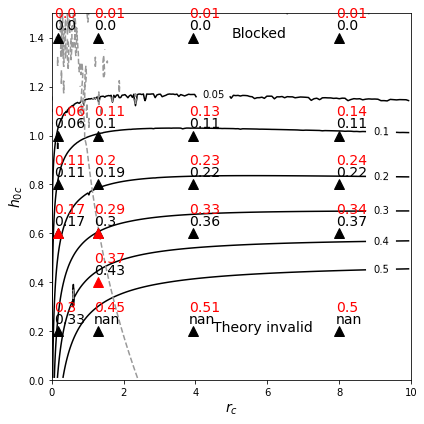

In [12]:
# plot Q1 as a function of rc and hc
fig, ax = plt.subplots(figsize=(6, 6))
h = ax.contour(rc[rc <= 10], bc[bc <= 1.5], Q1[:, rc <= 10][bc <= 1.5, :], levels=dQ, colors='k')
plt.clabel(h, fmt='%1.1f')

# plot boundaries of Q1 that actually make sense : [0+0.05,0.5-0.05]
h = ax.contour(rc[rc <= 10], bc[bc <= 1.5], Q1[:, rc <= 10][bc <= 1.5, :], [Q/10], colors='k')
plt.clabel(h, fmt='%1.2f')
# ax.contour(rc, bc, Q1, [Q-Q/10], colors='k')
h = ax.contour(rc[rc <= 10], bc[bc <= 1.5], Q1[:, rc <= 10][bc <= 1.5, :], [Q], colors='k')
plt.clabel(h, fmt='%1.1f')

# right of the dash line, flow speed are negative
ax.contour(rc[rc <= 10], bc[bc <= 1.5], vl.real[:, rc <= 10][bc <= 1.5, :], [0.0], colors='0.6', linestyles='dashed')
# # for Q1> upper limit, "Blocked" ; for Q1< lower limit, 'Separated or Uncontrolled'
plt.text(5, 1.4, 'Blocked', fontsize=14, color='k')
plt.text(4.5, 0.2, 'Theory invalid', fontsize=14, color='k')

for i in range(len(rn)):
    for j in range(len(hn)):
        ax.plot(rn[i], hn[j], marker='^', color='k', markersize=10)
        plt.text(rn[i]-0.1, hn[j]+0.03, np.round(Q1s[i, j], 2),
                 fontsize=14, color='k')

for i in range(len(rm)):
    plt.text(rm[i]-0.1, hm[i]+0.08, np.round(Q1m[i], 2),
             fontsize=14, color='r')

for i in range(len(rms)):
    plt.text(rms[i]-0.1, hms[i]+0.08,
             np.round(Q1ms[i], 2), fontsize=14, color='r')
    
# mark the three results: w1c=20km, b1c=600m; w1c=50km, b1c=600m; w1c=50km, b1c=400m
ax.plot(rsn[0], hsn[0], marker='^', color='r', markersize=10)
ax.plot(rsn[1], hsn[0], marker='^', color='r', markersize=10)
ax.plot(rsn[0], hsn[1], marker='^', color='r', markersize=10)
plt.text(rsn[0]-0.1, hsn[1]+0.03, np.round(.4316, 2), fontsize=14, color='k')

ax.set(ylim=(0, 1.5))
ax.set(xlim=(0, 10))
ax.set_ylabel('${h_0}_c$', fontsize=14)
ax.set_xlabel('$r_c$', fontsize=14)
ax.set_title('')
plt.tight_layout()


# Plot model results
Please contact S.Tan for the full model output 

In [10]:
def extract_data(Data):
    """ Extract and regulate data from xarray Dataset. (x, y) - (east, north)"""
    # ragulate data
    t = Data.time.data
    d = Data.H.data
    v = Data.U.data # northward
    u = Data.V.data # westward
    h = Data.B.data
    # dims=['time', 'y', 'x']
    # (y, x) is in fact (west, north) convert to (x, y) or (east, north)
    u = -u[:,::-1,:] # now the flow speed is toward east
    v = v[:,::-1,:]
    d = d[:,::-1,:]
    h = h[::-1,:]
    x = Data.y.data 
    y = Data.x.data
    return x,y,t,d,h,v

def find_nearest(array, value):
    """ Find the nearest point of
        code stolen from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


## Fig. 4

In [11]:
# pick out model runs that you want to show in Fig. 4 and Fig. 11
# also set up the location of subplots
idx_Q1m = np.array([0, 1, 3, 5, 8, 7])
ax_Q1m = np.empty((4, len(idx_Q1m)))
for i in range(1,4):
    ax_Q1m[:, i-1] = np.array([.04 + .24*i, .04, .2, .2])
ax_Q1m[:, 3] = np.array([.04 + .24*3, .04 + .24, .2, .2])
ax_Q1m[:, 4] = np.array([.04 + .24*3, .04 + .24*2, .2, .2])
ax_Q1m[:, 5] = np.array([.04 , .04 + .24*2, .2, .2])
label_Q1m = ['(e)', '(f)', '(g)', '(h)', '(i)', '(b)']
name_Q1m = np.arange(1,18+1e-4,1)

idx_Q1m1 = np.array([0])
ax_Q1m1 = np.empty((4, len(idx_Q1m1)))
ax_Q1m1[:, 0] = np.array([.04, .04 + .24, .2, .2])
label_Q1m1 = ['(c)']
name_Q1m1 = np.arange(1,4+1e-4,1)

idx_Q1ms = np.array([1])
ax_Q1ms = np.empty((4, len(idx_Q1ms)))
ax_Q1ms[:, 0] = np.array([.04, .04, .2, .2])
label_Q1ms = ['(d)']
name_Q1ms = np.array([1, 2])

/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support t

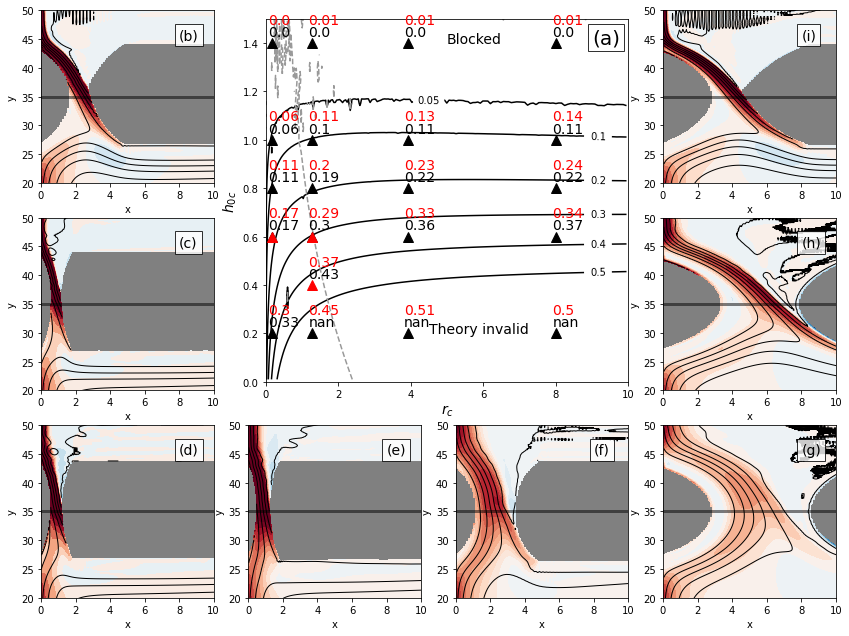

In [22]:
# average time period
t_s = 100
t_e = 400

# plot Q1 as a function of rc and hc, plus a lot of insets on model snapshots
from matplotlib import cm

fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([.3, .29, .42, .42])

h = ax.contour(rc[rc <= 10], bc[bc <= 1.5], Q1[:, rc <= 10][bc <= 1.5, :], levels=dQ, colors='k')
plt.clabel(h, fmt='%1.1f')

# plot boundaries of Q1 that actually make sense : [0+0.05,0.5-0.05]
h = ax.contour(rc[rc <= 10], bc[bc <= 1.5], Q1[:, rc <= 10][bc <= 1.5, :], [Q/10], colors='k')
plt.clabel(h, fmt='%1.2f')
# ax.contour(rc, bc, Q1, [Q-Q/10], colors='k')
h = ax.contour(rc[rc <= 10], bc[bc <= 1.5], Q1[:, rc <= 10][bc <= 1.5, :], [Q], colors='k')
plt.clabel(h, fmt='%1.1f')

# right of the dash line, flow speed are negative
ax.contour(rc[rc <= 10], bc[bc <= 1.5], vl.real[:, rc <= 10][bc <= 1.5, :], [0.0], colors='0.6', linestyles='dashed')
# # for Q1> upper limit, "Blocked" ; for Q1< lower limit, 'Separated or Uncontrolled'
plt.text(5, 1.4, 'Blocked', fontsize=14, color='k')
plt.text(4.5, 0.2, 'Theory invalid', fontsize=14, color='k')

for i in range(len(rn)):
    for j in range(len(hn)):
        ax.plot(rn[i], hn[j], marker='^', color='k', markersize=10)
        ax.text(rn[i]-0.1, hn[j]+0.03, np.round(Q1s[i, j], 2),
                 fontsize=14, color='k')

for i in range(len(rm)):
    ax.text(rm[i]-0.1, hm[i]+0.08, np.round(Q1m[i], 2),
             fontsize=14, color='r')

for i in range(len(rms)):
    ax.text(rms[i]-0.1, hms[i]+0.08,
             np.round(Q1ms[i], 2), fontsize=14, color='r')

# mark the three results: w1c=20km, b1c=600m; w1c=50km, b1c=600m; w1c=50km, b1c=400m
ax.plot(rsn[0], hsn[0], marker='^', color='r', markersize=10)
ax.plot(rsn[1], hsn[0], marker='^', color='r', markersize=10)
ax.plot(rsn[0], hsn[1], marker='^', color='r', markersize=10)
plt.text(rsn[0]-0.1, hsn[1]+0.03, np.round(.4316, 2), fontsize=14, color='k')

ax.set(ylim=(0, 1.5))
ax.set(xlim=(0, 10))
ax.set_ylabel('${h_0}_c$', fontsize=14)
ax.set_xlabel('$r_c$', fontsize=14)
ax.set_title('')
ax.text(9, 1.4, '(a)', fontsize=20, color='black', bbox=dict(facecolor='white', alpha=0.8))


for i in range(len(idx_Q1m)):
    ax_ = fig.add_axes(ax_Q1m[:,i])    
    model_path = '/Volumes/GeneralBackup/backup_20210905/Desktop - Shuwen’s MacBook Pro/WORK/MODEL/Onelayer/try5/OutOfGill/'
    Data = xr.open_dataset(model_path + 'Data_' + np.str(np.int(name_Q1m[idx_Q1m[i]])) + '.nc')
    x, y, t, d, h, v = extract_data(Data)
    v[d < 1e-7] = np.nan
    d[d < 1e-7] = np.nan
    a, idx_ts = find_nearest(t, t_s)
    a, idx_te = find_nearest(t, t_e)
    ax_.contour(x, y, np.squeeze(np.mean(d[idx_ts:idx_te,:,:], axis=0)).T+h.T, levels=np.arange(0, 2+1e-4, 0.1, dtype=float),
                linewidths=1, colors='k')
    ax_.contourf(x, y, np.squeeze(np.mean(v[idx_ts:idx_te,:,:], axis=0)).T, cmap=cm.RdBu_r, levels=20, 
                 vmin=-0.5, vmax=0.5)
    ax_.plot([0, 10], [35, 35], color='k', lw=3, alpha=.5)
    ax_.set_facecolor("grey")
    ax_.set_title('')
    ax_.set_xlabel('x')
    ax_.set_ylabel('y')
    ax_.set_xlim([0, 10])
    ax_.set_ylim([20, 50])
    ax_.text(8, 45, label_Q1m[i], fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.8))
    
for i in range(len(idx_Q1m1)):
    ax_ = fig.add_axes(ax_Q1m1[:,i])    
    model_path = '/Volumes/GeneralBackup/backup_20210905/Desktop - Shuwen’s MacBook Pro/WORK/MODEL/Onelayer/try5/OutOfGill1/'
    Data = xr.open_dataset(model_path + 'Data_' + np.str(np.int(name_Q1m1[idx_Q1m1[i]])) + '.nc')
    x, y, t, d, h, v = extract_data(Data)
    v[d < 1e-7] = np.nan
    d[d < 1e-7] = np.nan
    a, idx_ts = find_nearest(t, t_s)
    a, idx_te = find_nearest(t, t_e)
    ax_.contour(x, y, np.squeeze(np.mean(d[idx_ts:idx_te,:,:], axis=0)).T+h.T, levels=np.arange(0, 2+1e-4, 0.1, dtype=float),
                linewidths=1, colors='k')
    ax_.contourf(x, y, np.squeeze(np.mean(v[idx_ts:idx_te,:,:], axis=0)).T, cmap=cm.RdBu_r, levels=20, 
                 vmin=-0.5, vmax=0.5)
    ax_.plot([0, 10], [35, 35], color='k', lw=3, alpha=.5)
    ax_.set_facecolor("grey")
    ax_.set_title('')
    ax_.set_xlabel('x')
    ax_.set_ylabel('y')
    ax_.set_xlim([0, 10])
    ax_.set_ylim([20, 50])
    ax_.text(8, 45, label_Q1m1[i], fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.8))

for i in range(len(idx_Q1ms)):
    ax_ = fig.add_axes(ax_Q1ms[:,i])    
    model_path = '/Volumes/GeneralBackup/backup_20210905/Desktop - Shuwen’s MacBook Pro/WORK/MODEL/Onelayer/try5/Par_1_finalexperiments/'  
    Data = xr.open_dataset(model_path + 'Data_' + np.str(np.int(name_Q1ms[idx_Q1ms[i]])) + '.nc')
    x, y, t, d, h, v = extract_data(Data)
    v[d < 1e-7] = np.nan
    d[d < 1e-7] = np.nan
    a, idx_ts = find_nearest(t, t_s)
    a, idx_te = find_nearest(t, t_e)
    ax_.contour(x, y, np.squeeze(np.mean(d[idx_ts:idx_te,:,:], axis=0)).T+h.T, levels=np.arange(0, 2+1e-4, 0.1, dtype=float),
                 linewidths=1, colors='k')
    ax_.contourf(x, y, np.squeeze(np.mean(v[idx_ts:idx_te,:,:], axis=0)).T, cmap=cm.RdBu_r, levels=20, 
                 vmin=-0.5, vmax=0.5)
    ax_.plot([0, 10], [35, 35], color='k', lw=3, alpha=.5)
    ax_.set_facecolor("grey")
    ax_.set_title('')
    ax_.set_xlabel('x')
    ax_.set_ylabel('y')
    ax_.set_xlim([0, 10])
    ax_.set_ylim([20, 50])
    ax_.text(8, 45, label_Q1ms[i], fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.8))
    
plt.tight_layout()
# plt.savefig('../pics/Fig4_before_modify.eps')
plt.savefig('../../review1/pics/Fig4_before_modify.eps')

## Fig. 8

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

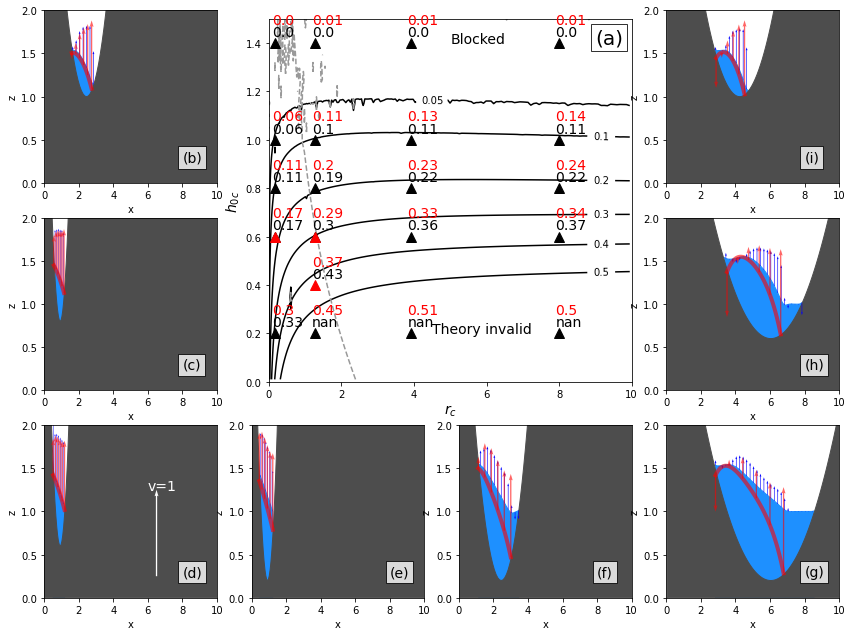

In [23]:
# sill location
yc = 35
# average time period
t_s = 100
t_e = 400
# plot Q1 as a function of rc and hc, plus a lot of insets on model snapshots
from matplotlib import cm

fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([.3, .29, .42, .42])

h = ax.contour(rc[rc <= 10], bc[bc <= 1.5], Q1[:, rc <= 10][bc <= 1.5, :], levels=dQ, colors='k')
plt.clabel(h, fmt='%1.1f')

# plot boundaries of Q1 that actually make sense : [0+0.05,0.5-0.05]
h = ax.contour(rc[rc <= 10], bc[bc <= 1.5], Q1[:, rc <= 10][bc <= 1.5, :], [Q/10], colors='k')
plt.clabel(h, fmt='%1.2f')
# ax.contour(rc, bc, Q1, [Q-Q/10], colors='k')
h = ax.contour(rc[rc <= 10], bc[bc <= 1.5], Q1[:, rc <= 10][bc <= 1.5, :], [Q], colors='k')
plt.clabel(h, fmt='%1.1f')

# right of the dash line, flow speed are negative
ax.contour(rc[rc <= 10], bc[bc <= 1.5], vl.real[:, rc <= 10][bc <= 1.5, :], [0.0], colors='0.6', linestyles='dashed')
# # for Q1> upper limit, "Blocked" ; for Q1< lower limit, 'Separated or Uncontrolled'
plt.text(5, 1.4, 'Blocked', fontsize=14, color='k')
plt.text(4.5, 0.2, 'Theory invalid', fontsize=14, color='k')

for i in range(len(rn)):
    for j in range(len(hn)):
        ax.plot(rn[i], hn[j], marker='^', color='k', markersize=10)
        ax.text(rn[i]-0.1, hn[j]+0.03, np.round(Q1s[i, j], 2),
                 fontsize=14, color='k')

for i in range(len(rm)):
    ax.text(rm[i]-0.1, hm[i]+0.08, np.round(Q1m[i], 2),
             fontsize=14, color='r')

for i in range(len(rms)):
    ax.text(rms[i]-0.1, hms[i]+0.08,
             np.round(Q1ms[i], 2), fontsize=14, color='r')

# mark the three results: w1c=20km, b1c=600m; w1c=50km, b1c=600m; w1c=50km, b1c=400m
ax.plot(rsn[0], hsn[0], marker='^', color='r', markersize=10)
ax.plot(rsn[1], hsn[0], marker='^', color='r', markersize=10)
ax.plot(rsn[0], hsn[1], marker='^', color='r', markersize=10)
plt.text(rsn[0]-0.1, hsn[1]+0.03, np.round(.4316, 2), fontsize=14, color='k')

ax.set(ylim=(0, 1.5))
ax.set(xlim=(0, 10))
ax.set_ylabel('${h_0}_c$', fontsize=14)
ax.set_xlabel('$r_c$', fontsize=14)
ax.set_title('')
ax.text(9, 1.4, '(a)', fontsize=20, color='black', bbox=dict(facecolor='white', alpha=0.8))

for i in range(len(idx_Q1m)):
    ax_ = fig.add_axes(ax_Q1m[:,i])   
    model_path = '/Volumes/GeneralBackup/backup_20210905/Desktop - Shuwen’s MacBook Pro/WORK/MODEL/Onelayer/try5/OutOfGill/'
    Data = xr.open_dataset(model_path + 'Data_' +
                           np.str(np.int(name_Q1m[idx_Q1m[i]])) + '.nc')
    Topo = xr.open_dataset(model_path + 'Topo_' +
                           np.str(np.int(name_Q1m[idx_Q1m[i]])) + '.nc')
    x, y, t, d, h, v = extract_data(Data)
    v[d < 1e-7] = np.nan
    d[d < 1e-7] = np.nan
    a, idx_ts = find_nearest(t, t_s)
    a, idx_te = find_nearest(t, t_e)
    a, l = find_nearest(y, yc)
    # h, model average between t=100 and t=400
    ita = np.squeeze(np.mean(d[idx_ts:idx_te,:,l], axis=0))+h[:, l]
    ax_.fill_between(x, ita, color='dodgerblue', label='h+d')
    ax_.fill_between(x, h[:, l], 0, color='0.3', label='d')
    ax_.quiver(x[::2], ita[::2], 0, np.squeeze(np.mean(v[idx_ts:idx_te,::2,l], axis=0)),
               scale=1, scale_units='y', lw=4, color='b')
    # h, Gill prediction
    l1 = np.where(wn == wm[idx_Q1m[i]])
    l2 = np.where(hn == hm[idx_Q1m[i]])
    h1 = np.squeeze(H1s[:, l1, l2])
    d1 = np.squeeze(D1s[:, l1, l2])
    v1 = np.squeeze(U1s[:, l1, l2])
    x1 = np.squeeze(X1s[:, l1, l2])
    x1 = x1 - x1[np.where(h1 == min(h1))] + (60 - Topo.y0.data)
    ax_.plot(x1, d1+h1, color='r', lw=4, alpha=0.6, label='(h+d)_Gill')
    ax_.quiver(x1[::10], d1[::10]+h1[::10], 0, v1[::10], scale=1,
               scale_units='y', lw=0.5, color='r', alpha=0.6)
    ax_.set_xlim([0, 10])
    ax_.set_ylim([0, 2])
    ax_.set_title('')
    ax_.set_xlabel('x')
    ax_.set_ylabel('z')  
    ax_.set_yticks(np.around(np.arange(0, 2+1e-4, step=0.5),2))
    ax_.text(8, .25, label_Q1m[i], fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.8))

wm1 = np.array([0.6, 1.6, 2.8, 4.0])
rm1 = (np.power((np.array(wm1)/2.0), 2)/dn)
hm1 = np.array([0.8, 0.8, 0.8, 0.8])

for i in range(len(idx_Q1m1)):
    ax_ = fig.add_axes(ax_Q1m1[:,i])   
    model_path = '/Volumes/GeneralBackup/backup_20210905/Desktop - Shuwen’s MacBook Pro/WORK/MODEL/Onelayer/try5/OutOfGill1/'
    Data = xr.open_dataset(model_path + 'Data_' +
                           np.str(np.int(name_Q1m1[idx_Q1m1[i]])) + '.nc')
    Topo = xr.open_dataset(model_path + 'Topo_' +
                           np.str(np.int(name_Q1m1[idx_Q1m1[i]])) + '.nc')
    x, y, t, d, h, v = extract_data(Data)
    v[d < 1e-7] = np.nan
    d[d < 1e-7] = np.nan
    a, idx_ts = find_nearest(t, t_s)
    a, idx_te = find_nearest(t, t_e)
    a, l = find_nearest(y, yc)
    # h, model average between t=100 and t=400
    ita = np.squeeze(np.mean(d[idx_ts:idx_te,:,l], axis=0))+h[:, l]
    ax_.fill_between(x, ita, color='dodgerblue', label='h+d')
    ax_.fill_between(x, h[:, l], 0, color='0.3', label='d')
    ax_.quiver(x[::2], ita[::2], 0, np.squeeze(np.mean(v[idx_ts:idx_te,::2,l], axis=0)),
               scale=1, scale_units='y', lw=4, color='b')
    # h, Gill prediction
    l1 = np.where(wn == wm1[idx_Q1m1[i]])
    l2 = np.where(hn == hm1[idx_Q1m1[i]])
    h1 = np.squeeze(H1s[:, l1, l2])
    d1 = np.squeeze(D1s[:, l1, l2])
    v1 = np.squeeze(U1s[:, l1, l2])
    x1 = np.squeeze(X1s[:, l1, l2])
    x1 = x1 - x1[np.where(h1 == min(h1))] + (60 - Topo.y0.data)
    ax_.plot(x1, d1+h1, color='r', lw=4, alpha=0.6, label='(h+d)_Gill')
    ax_.quiver(x1[::10], d1[::10]+h1[::10], 0, v1[::10], scale=1,
               scale_units='y', lw=0.5, color='r', alpha=0.6)
    ax_.set_xlim([0, 10])
    ax_.set_ylim([0, 2])
    ax_.set_title('')
    ax_.set_xlabel('x')
    ax_.set_ylabel('z')  
    ax_.set_yticks(np.around(np.arange(0, 2+1e-4, step=0.5),2))
    ax_.text(8, .25, label_Q1m1[i], fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.8))

for i in range(len(idx_Q1ms)):
    ax_ = fig.add_axes(ax_Q1ms[:,i])    
    model_path = '/Volumes/GeneralBackup/backup_20210905/Desktop - Shuwen’s MacBook Pro/WORK/MODEL/Onelayer/try5/Par_1_finalexperiments/'
    Data = xr.open_dataset(model_path + 'Data_' +
                           np.str(np.int(name_Q1ms[idx_Q1ms[i]])) + '.nc')
    Topo = xr.open_dataset(model_path + 'Topo_' +
                           np.str(np.int(name_Q1ms[idx_Q1ms[i]])) + '.nc')
    x, y, t, d, h, v = extract_data(Data)
    v[d < 1e-7] = np.nan
    d[d < 1e-7] = np.nan
    a, idx_ts = find_nearest(t, t_s)
    a, idx_te = find_nearest(t, t_e)
    a, l = find_nearest(y, yc)
    # h, model average between t=100 and t=400
    ita = np.squeeze(np.mean(d[idx_ts:idx_te,:,l], axis=0))+h[:, l]
    ax_.fill_between(x, ita, color='dodgerblue', label='h+d')
    ax_.fill_between(x, h[:, l], 0, color='0.3', label='d')
    ax_.quiver(x[::2], ita[::2], 0, np.squeeze(np.mean(v[idx_ts:idx_te,::2,l], axis=0)),
               scale=1, scale_units='y', lw=4, color='b')
    # h, Gill prediction
    l1 = np.where(wn == wms[idx_Q1ms[i]])
    l2 = np.where(hn == hms[idx_Q1ms[i]])
    h1 = np.squeeze(H1s[:, l1, l2])
    d1 = np.squeeze(D1s[:, l1, l2])
    v1 = np.squeeze(U1s[:, l1, l2])
    x1 = np.squeeze(X1s[:, l1, l2])
    x1 = x1 - x1[np.where(h1 == min(h1))] + (60 - Topo.y0.data)
    ax_.plot(x1, d1+h1, color='r', lw=4, alpha=0.6, label='(h+d)_Gill')
    ax_.quiver(x1[::10], d1[::10]+h1[::10], 0, v1[::10], scale=1,
               scale_units='y', lw=0.5, color='r', alpha=0.6)
    ax_.set_xlim([0, 10])
    ax_.set_ylim([0, 2])
    ax_.set_title('')
    ax_.set_xlabel('x')
    ax_.set_ylabel('z')  
    ax_.set_yticks(np.around(np.arange(0, 2+1e-4, step=0.5),2))
    ax_.text(8, .25, label_Q1ms[i], fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.8))
    ax_.quiver(6.5, 0.25, 0, 1,
              scale=1, scale_units='y', color='w')
    ax_.text(6,1.25, 'v=1', fontsize=14, color='w')
    
# plt.savefig('../pics/Fig8_before_modify.eps')
plt.savefig('../../review1/pics/Fig8_before_modify.eps')